In [2]:
import pandas as pd
import graphlab as gl
import numpy as np
from IPython.core.display import display
from scipy.spatial.distance import cosine,euclidean,pdist,squareform
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import entropy
from numpy.linalg import norm
from jenks import jenks
from itertools import chain,tee, izip
from urllib import unquote_plus
from titlecase import titlecase
from itertools import combinations
import itertools
import seaborn

In [3]:
# GLOBAL PARAMS
SESSION_THRESHOLD = 1800 # 30 minutes
MIN_LENGTH = 5 # Minimum number of scrobbles in a patch

In [4]:
### Load some example data
me = pd.read_table("../testData/mylistening.txt",header=None,
            names=['user_id','item_id','artist_id','ts'],parse_dates=['ts']).sort('ts')
### Build artist_name:artist_idx dict from 
artist_idx = {}
for line in open('../GenreModeling/data/vocab_idx'):
    line = line.strip().split('\t')
    artist_idx[line[0]] = int(line[1])
### Load artist feature matrix
features = np.load('../GenreModeling/data/features/lda_artists/features_190.npy')

/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [5]:
### Build artist_id:artist_name and artist_name:artist_idx dicts from database data
artist_ids = {}
artist_names = {}
for line in open('../GenreModeling/data/artist_ids'):
    line = line.strip().split('\t')
    artist_ids[int(line[0])] = line[1]
    artist_names[line[1]] = int(line[0])
    
# Lookup function to get features for a given artist ID or artist name
def get_features(aid=None,artist_name=None):
    if artist_name is None:
        artist_name = artist_ids.get(aid)
        if not artist_name: 
            return np.repeat(np.nan,features.shape[1])
    return features[artist_idx[artist_name]]

# Function for Jensen Shannon Distance (Sqrt of Jensen Shannon Divergence)
def JSD(P, Q):
    if np.all(np.isnan(P)) or np.all(np.isnan(Q)):
        return np.nan
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return np.sqrt(np.clip(0.5 * (entropy(_P, _M) + entropy(_Q, _M)),0,1))

# Function to calculate distance between any two artists 
def calc_sim(artist1,artist2,metric='cosine'):
    if np.isnan(artist1) or np.isnan(artist2):
        return np.nan
    if artist1==artist2:
        return 0.0
    features1 = get_features(artist1)
    if np.all(np.isnan(features1)): return np.nan
    features2 = get_features(artist2)
    if np.all(np.isnan(features2)): return np.nan
    if metric == 'JSD':
        return JSD(features1,features2)
    elif metric == 'cosine':
        return cosine(features1,features2)
    elif metric == 'euclidean':
        return euclidean(features1,features2)

# for proper formatting of artist names
def formatter(s):
    if s:
        try: return titlecase(unquote_plus(s))
        except: return s
    return 'UNKNOWN'

# Just a clean format for presenting example dataframes 
def pres_format(input_df):
    df = input_df.copy()
    df = df[['ts','artist_name','dist']].reset_index(drop=True)
    df.columns = ['timestamp','artist','distance']
    df['artist'] = df['artist'].apply(formatter)
#    df['previous artist'] = df['previous artist'].apply(formatter)
    return df

In [6]:
# All pre-formatting of data
new = me.copy()
new['before'] = new.shift(1)['artist_id']
new['td'] = new['ts']-new.shift(1)['ts']
new['td'] = new['td'].astype(int) / 10**9
new['artist_name'] = new.apply(lambda row: artist_ids.get(row['artist_id']),axis=1)
new['before_name'] = new.shift(1)['artist_name']
new = new[['ts','artist_id','before','td','artist_name','before_name']]
new['dist'] = new.apply(lambda row: calc_sim(row['artist_id'],row['before']),axis=1)
new['features'] = new['artist_name'].apply(lambda a: get_features(artist_name=a))
new = new.reset_index(drop=True)

In [7]:
### Add session index information
session_idx = 0
session_indices = []
for val in new['td']>=SESSION_THRESHOLD:
    if val:
        session_idx +=1
    session_indices.append(session_idx)
new['session'] = session_indices
#session_counts = new['session'].value_counts()
#new = new[new['session'].isin(session_counts[session_counts>=MIN_LENGTH].index)]

In [8]:
### for now we'll just ignore sessions with unknown artists, but should do something more clever in the future
def remove_sessions_with_unknowns(df):
    if df['artist_name'].hasnans:
        return None
    else:
        return df
#new = new.groupby('session').apply(remove_sessions_with_unknowns).reset_index(drop=True)


In [9]:
### Add patch index information
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return izip(a, b)

s=20
dist_thresh = 0.2

def patch_segmenter(df):
    l = df['artist_id']
    indices = list(np.array([len(list(v)) for g,v in itertools.groupby(l)][:-1]).cumsum())
    new_indices = []

    for b in indices:
        try:
            dist = cosine(df.iloc[b]['features'],df.iloc[b-1]['features'])
        except ValueError:
            dist = 1.
        #print b,test.iloc[b-1]['artist_name'],test.iloc[b]['artist_name'],dist
        if dist >= dist_thresh:
            new_indices.append(b)
    
    if new_indices:

        last_patch = False
        final_indices = []
        for i,(a,b) in enumerate(pairwise([0]+new_indices+[len(df)])):
            if b-a>=MIN_LENGTH:
                final_indices.append(a)
                last_patch = True
            else:
                if last_patch:
                    final_indices.append(a)
                last_patch = False
        
        return final_indices
    return new_indices
        
#test = new
#test = new[new['session']==20].copy()
test = new
indices = np.zeros(len(test),dtype=int)       
offset = 0
idx=0

for session in test.groupby('session'):
    result = patch_segmenter(session[1])
    n=len(session[1])
    if len(result)==0:
        indices[offset:offset+n] = idx
        idx+=1
    else:
        indices[offset:offset+result[0]] = idx
        idx+=1
        for v, w in pairwise(result):
            indices[offset+v:offset+w] = idx
            idx+=1
        indices[offset+result[-1]:offset+result[-1]+n] = idx
        idx+=1
    offset += n
if result:
    indices[offset+result[-1]:] = idx
else:
    indices[offset:] = idx
test['patch_idx'] = indices


In [15]:
new[(new['dist']<0.2)&(new['dist']>0)]

,ts,artist_id,before,td,artist_name,before_name,dist,features,session,patch_idx
42,2007-02-25 17:47:18,1994,1727.0,223.0,the+white+stripes,radiohead,0.106606,"[0.000130706414263, 0.000504450163439, 0.00015...",5,5
45,2007-02-25 17:58:41,13413,42105.0,306.0,jedi+mind+tricks,aesop+rock,0.114177,"[3.68880013144e-07, 3.68880013144e-07, 3.68880...",5,5
64,2007-02-26 06:36:44,7175,10716.0,237.0,the+offspring,alien+ant+farm,0.139978,"[1.50881791794e-05, 0.00808933853112, 6.961307...",6,6
66,2007-02-26 07:00:44,10305,42105.0,1252.0,atmosphere,aesop+rock,0.052671,"[0.000317032454626, 0.00612361336301, 0.000168...",6,6
144,2007-02-27 20:47:48,1761,3511.0,185.0,the+strokes,franz+ferdinand,0.052997,"[0.000457633087542, 0.00310547481422, 4.557826...",11,15
218,2007-03-02 04:02:22,1727,507.0,179.0,radiohead,beck,0.176106,"[0.000428501969522, 3.62170571871e-05, 6.74461...",20,24
220,2007-03-02 04:22:22,3014,43708.0,274.0,at+the+drive-in,sparta,0.088306,"[1.79202689245e-07, 0.017360152999, 1.79202689...",20,25
253,2007-03-02 06:21:20,243062,11508.0,345.0,antonio+carlos+jobim+&+elis+regina,caetano+veloso,0.066404,"[8.78804123349e-06, 8.78804123349e-06, 8.78804...",20,28
266,2007-03-02 07:44:00,16711,22478.0,250.0,david+draiman,wayne+static,0.178744,"[0.00192437217358, 7.75956521604e-06, 0.022240...",21,29
267,2007-03-02 07:47:39,21894,16711.0,219.0,chester+bennington,david+draiman,0.156486,"[4.70555019646e-06, 0.000576900454086, 0.01253...",21,29


In [643]:
# calculate diversity of each patch
def calc_diversity(grp):
    return (len(grp['artist_id'].unique())/float(len(grp))) * grp['dist'].mean()
#patch_diversities = new.groupby('patch_idx').apply(calc_diversity)

# calculate centroid of each patch
def calc_centroid(grp):
    return list(np.nanmean([get_features(i) for i in grp['artist_id']],axis=0))
#patch_centroids=np.array(list(new.groupby('patch_idx').apply(calc_centroid)))


def patch_stats(df):
    first = df.iloc[0]
    diversity = (len(df['artist_id'].unique())/float(len(df))) * df['dist'].mean()
    centroid = np.nanmean([get_features(i) for i in df['artist_id']],axis=0)

    artists = df['artist_id'].values
    n = len(df)
    start = first['ts']
    return pd.Series({'diversity':diversity,'centroid':centroid,'start':start,'n':n,'artists':artists})
    
result = new.groupby('patch_idx').apply(patch_stats)#.reset_index(level=1,drop=True)
    
result

# ditto for sessions
#session_diversities = new.groupby('session').apply(calc_diversity)
#session_centroids=np.array(list(new.groupby('session').apply(calc_centroid)))


,artists,centroid,diversity,n,start
patch_idx,,,,,
0,"[405, 11337, 4536]","[0.00910346771546, 0.00321661934279, 0.0004106...",0.876161,3,2007-02-24 22:54:28
1,"[42105, 3014, 1996, 1328, 7432, 405, 3875, 107...","[0.0023106247869, 0.00485564868551, 0.00047131...",0.588997,26,2007-02-25 01:55:39
2,"[3608244, 7175, 117398, 405, 73, 10739, 1996, ...","[0.00061228629818, 0.00185341876792, 0.0052659...",0.655306,9,2007-02-25 04:27:05
3,[11617],"[1.0283260641e-06, 1.0283260641e-06, 1.0283260...",0.986047,1,2007-02-25 05:37:58
4,[234068],"[0.0340613390288, 0.0973983645046, 2.649863002...",0.997020,1,2007-02-25 06:27:08
5,"[8033, 1727, 1994, 4530, 42105, 13413, 1761]","[0.0001460171507, 0.000527199327539, 0.0004084...",0.639499,7,2007-02-25 17:40:56
6,"[130, 13935, 40129, 125, 2965, 2003, 131549, 1...","[0.00102270520795, 0.00846726736392, 0.0219155...",0.687874,22,2007-02-26 05:24:11
7,"[376, 376, 376, 376, 376, 376, 376, 376, 376, ...","[5.32254464546e-06, 0.00297989085737, 9.176801...",0.003714,16,2007-02-26 07:07:20
8,"[3014, 3014]","[1.79202689245e-07, 0.017360152999, 1.79202689...",0.065533,2,2007-02-26 09:01:11


In [505]:
top_artists = new['artist_id'].value_counts().reset_index()
top_artists.columns = ['artist_id','scrobbles']
top_artists['artist_name'] = top_artists['artist_id'].apply(lambda x: artist_ids.get(x))


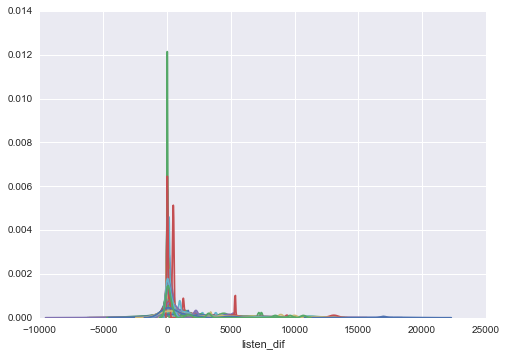

In [538]:
### https://stackoverflow.com/questions/14358567/finding-consecutive-segments-in-a-pandas-data-frame
# x = test[['artist_id','artist_name','ts','dist','session']].copy()
# x['block'] = (x['artist_id'].shift(1) != x['artist_id']).astype(int).cumsum()

# counts = x.reset_index().groupby(['artist_id','session','block']).count()['index'].values
# result = x.reset_index().groupby(['artist_id','session','block']).agg(lambda df: df.iloc[0]).reset_index()#(drop=True)
# result['n'] = counts

def calc_shifts(df):
    #df = result[result['artist_id']==8029]
    df['listen_dif'] = df['index']-df['index'].shift(1)
    df['time_dif'] = (df['ts']-df['ts'].shift(1)).apply(lambda t: t.total_seconds())
    return df
# shifted = result.merge(top_artists[:100],on='artist_id').groupby('artist_id').apply(calc_shifts)
for artist in shifted['artist_name_x'].unique():
    plot_data = shifted[(shifted['artist_name_x']==artist)&(shifted['n']>=5)]['listen_dif'].dropna()
    if len(plot_data)>1:
        seaborn.distplot(plot_data,hist=False)


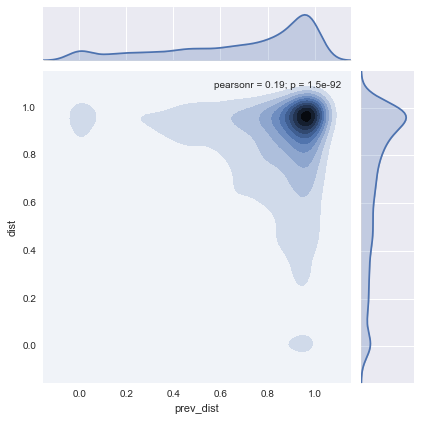

In [548]:
srt = shifted.sort_values(by='ts')
srt['prev_dist'] = srt['dist'].shift(1)
seaborn.jointplot(data=srt,x='prev_dist',y='dist',kind='kde')

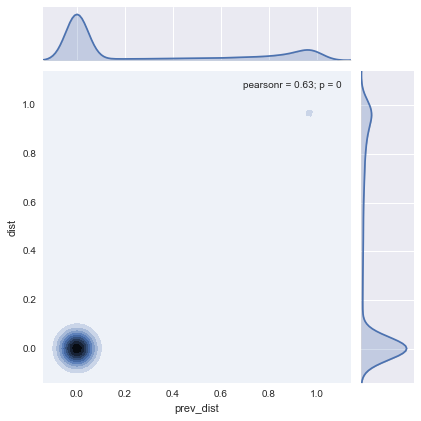

In [550]:
new['prev_dist'] = new['dist'].shift(1)
seaborn.jointplot(data=new,x='prev_dist',y='dist',kind='kde')

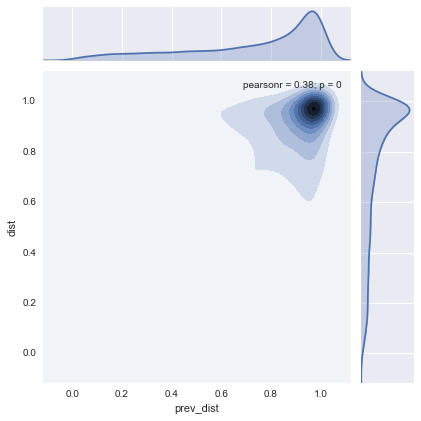

In [552]:
seaborn.jointplot(data=new[(new['dist']>0)&(new['prev_dist']>0)],x='prev_dist',y='dist',kind='kde')

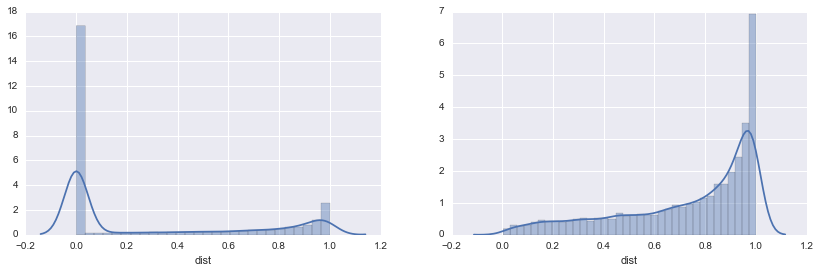

In [559]:
fig,axes = plt.subplots(1,2,figsize=(14,4))
seaborn.distplot(new['dist'].dropna(),ax=axes[0])
seaborn.distplot(new['dist'][new['dist']>0].dropna(),ax=axes[1])

(5153,)


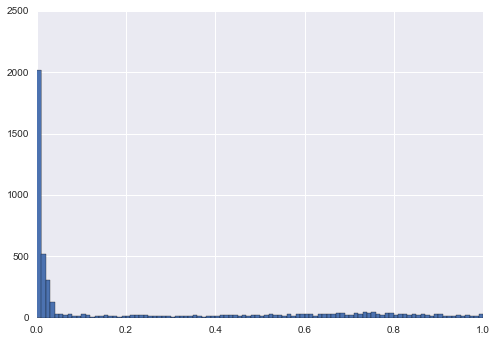

In [308]:
print patch_diversities.dropna().shape
#ax = seaborn.distplot(patch_diversities.dropna())
patch_diversities.hist(bins=100)

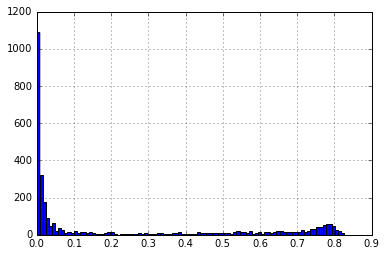

In [482]:
pd.Series(patch_diversities).hist(bins=100)

In [589]:
#patch_diversities
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenks(array, classes)
    #print classes

    # do the actual classification
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

# arr = new['td'][new['td']<=7200].values
# x=[]
# for nClasses in xrange(2,10):
#     print nClasses,goodness_of_variance_fit(arr, nClasses)
#     #x.append(goodness_of_variance_fit(arr, nClasses))

In [648]:
# print jenks(arr,3)[1:-1]
#jenks(patch_diversities[~np.any(np.isnan(patch_centroids),axis=1)],3)
blerg = result[(result['diversity']>0)&(result['n']>=MIN_LENGTH)]['diversity']
print jenks(blerg.dropna(),2)
blerg.describe()


[6.0692156e-07, 0.34382248, 0.98580658]


count    3.828000e+03
mean     2.342329e-01
std      3.095398e-01
min      6.069216e-07
25%      6.214022e-03
50%      2.148238e-02
75%      5.221113e-01
max      9.858066e-01
Name: diversity, dtype: float64

In [624]:
   
centroids = result[(result['diversity']<=0.34382248)&(result['n']>=5)]['centroid']
#distances = pairwise_distances(centroids, metric='cosine', n_jobs=-1)
#af = AffinityPropagation(affinity='precomputed')
#af.fit(1-distances)


((3193,), (3193,))

In [651]:
q = centroids.apply(np.mean)
q[np.isnan(q)]
centroids[184]
np.all(np.isnan(result['centroid']))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

(0, 0.1)

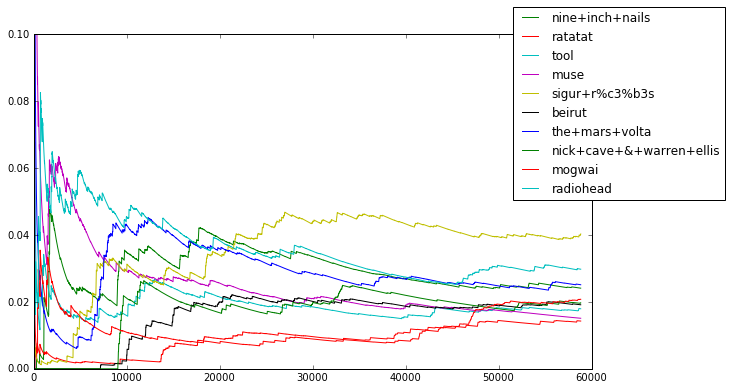

In [491]:
top10 = me['artist_id'].value_counts()[:10]

d_cnts = {i:[0] for i in top10.index}
#d_props = {i:[] for i in top10.index}
for i in xrange(1,len(me)):
    current = me[:i]['artist_id'].value_counts()
    for artist in top10.index:
        try: 
            cnt = float(current[artist])
        except KeyError:
            cnt = 0.
        d_cnts[artist].append(cnt)

fig,ax=plt.subplots(1,1,figsize=(10,6))
ax.plot(result)
for a in d_cnts:
    ax.plot(np.array(d_cnts[a])/np.array(range(len(me))),label = artist_ids[a])
ax.legend(loc='upper right',bbox_to_anchor=(1.25,1.1))
ax.set_ylim(0,0.1)